In [4]:
#数据读取 为了方便大家更好的理解数据，我们重命名为中文
import numpy  as np
import pandas as pd
import os
data      = pd.read_csv("/Users/zhusx/Desktop/kaggle_dataset/欺诈风险识别-上传/账户交易信息.csv", encoding="gbk")
train     = pd.read_csv("/Users/zhusx/Desktop/kaggle_dataset/欺诈风险识别-上传/训练集标签.csv", encoding="gbk")
user_info = pd.read_csv("/Users/zhusx/Desktop/kaggle_dataset/欺诈风险识别-上传/账户静态信息.csv", encoding="utf-8")
test      = pd.read_csv("/Users/zhusx/Desktop/kaggle_dataset/欺诈风险识别-上传/test_dataset.csv", encoding="utf-8")
data = data.rename({
                    'jylsxh': '交易流水序号',
                    'zhdh': '账户代号',
                    'dfzh': '对方账号',
                    'jdbz': '借贷标志',
                    'jyje': '交易金额',
                    'jyye': '交易余额',
                    'dfhh': '对方行号',
                    'jyrq': '交易日期',
                    'jysj': '交易时间',
                    'jyqd': '交易渠道',
                    'zydh': '摘要代号',
                    'jdbj': '借贷标记',
                    'zhye': '账户余额',
                    'dfmccd': '对方名称长度'}, axis=1
                  )

train    = train.rename({'zhdh': '账户代号', 
                         'black_flag': '标签'}, axis=1
                       )

user_info =  user_info.rename({'zhdh': '账户代号',
                               'khrq':'开户日期', 
                               'xb': '性别', 
                             'khjgdh':'开户机构代号'}, axis=1
                              )

test    =  test.rename({'zhdh': '账户代号'},axis=1)

In [5]:
# 对数据进行聚合
df = data.groupby(['账户代号','对方账号']).agg({'交易流水序号': pd.Series.nunique}).reset_index()
print('聚合数据总数:\n',df.shape)

# 剔除自己指向自己的节点
df = df[df['账户代号']!=df['对方账号']]
print('剔除后的数据:\n',df.shape)

聚合数据总数:
 (194263, 3)
剔除后的数据:
 (193576, 3)


In [61]:
import networkx as nx
# 常规-图数据转换
da = df[['账户代号','对方账号']].values
G  = nx.Graph()
for num in range(len(da)):
    G.add_edge(str(da[num,0]),str(da[num,1]))
    

In [62]:
####################################################################
#LPA 算法
print('LPA算法开始...')
from networkx.algorithms.community import asyn_lpa_communities as lpa
com = list(lpa(G))
#格式整理
df_com_lpa = pd.DataFrame()
for i in range(0,len(com)):
    d = pd.DataFrame({'Group_id':[i]*len(com[i]),'账户代号':list(com[i])})
    df_com_lpa = pd.concat([df_com_lpa,d])


LPA算法开始...


In [63]:
df_com_lpa.head(2)

Group_id              账户代号
0         0  FEBB883D6A810D4F
1         0  BB018F0527A8FA69

In [64]:
# 算法分群模块
import networkx as nx
import matplotlib.pyplot as plt



####################################################################
#极大连通子图算法
print('极大连通子图...')
com = list(nx.connected_components(G))
#格式整理
df_com_connected  = pd.DataFrame()
for i in range(0, len(com)):
    d = pd.DataFrame({'Group_id': [i] * len(com[i]), '账户代号': list(com[i])})
    df_com_connected = pd.concat([df_com_connected,d])



极大连通子图...


In [65]:
df_com_connected.head(2)

Group_id              账户代号
0         0  445B38ADAB0A016E
1         0  761A49C96E0D098B

In [66]:
#Louvain算法
print('Louvain算法...')
from community import community_louvain
com = community_louvain.best_partition(G)
#格式整理
df_com_louvain = pd.DataFrame()
df_com_louvain = pd.DataFrame({'Group_id':com.values(),
                               '账户代号':com.keys()}
                             )
print('计算结束')


Louvain算法...
计算结束


In [67]:
df_com_louvain.head(2)

Group_id              账户代号
0         0  00037295453A928A
1         1  0F76A363EACBDEAF

In [72]:

# 分群结果概览
'''
团伙用户数统计 
df_com_connected
df_com_lpa
df_com_louvain
'''

df_com_lpa.groupby('Group_id').count().sort_values(by = '账户代号',ascending=False).head(10)

账户代号
Group_id       
0         20332
197        6187
112        2868
728        2129
730        1319
109        1185
552        1123
175        1065
226        1046
110         980

In [74]:
train['标签'].value_counts()

0    900
1    300
Name: 标签, dtype: int64

In [76]:
# 社群数据画像
'''
pandasql 可以把SQL代码写到这里，有些复杂的逻辑方便SQL写，
并且日常应用也好参考,
没有的安装下 pip install pandasql

# 交替看看三个算法的情况
df_com_connected
df_com_lpa
df_com_louvain

'''

from   pandasql import sqldf
query = '''
SELECT group_id, all_cnt, test_cnt, train_0_cnt, train_1_cnt, 
	round( cast( train_1_cnt AS DOUBLE )/( train_0_cnt + train_1_cnt ),4 ) AS rate 
FROM
	(
	SELECT
		a.group_id,
		count( a.账户代号 ) AS all_cnt,
		sum( CASE WHEN 标签 = 0 THEN 1 ELSE 0 END ) AS train_0_cnt,
		sum( CASE WHEN 标签 = 1 THEN 1 ELSE 0 END ) AS train_1_cnt,
		sum( CASE WHEN c.账户代号 IS NOT NULL THEN 1 ELSE 0 END ) AS test_cnt 
	FROM
		( SELECT group_id, 账户代号 FROM df_com_louvain -- 替换算法结果
		) a
		LEFT JOIN ( SELECT 账户代号, 标签 FROM train ) b ON a.账户代号 = b.账户代号
		LEFT JOIN ( SELECT 账户代号 FROM test ) c ON a.账户代号 = c.账户代号 
	GROUP BY
		group_id 
	) a 
ORDER BY
	train_1_cnt DESC 
	LIMIT 2000 
'''

sqldf(query).head(20)


group_id  all_cnt  test_cnt  train_0_cnt  train_1_cnt    rate
0          1    10633      1058          207           82  0.2837
1          2    13881      1048          211           27  0.1134
2          3     3388       151           37           12  0.2449
3          8     2860        74            2           11  0.8462
4         27     1205        43            1           11  0.9167
5         65      874        19            2            9  0.8182
6          6     3260       200           53            8  0.1311
7         31     1601        36            1            8  0.8889
8         24     1099        52           15            6  0.2857
9          5     1346        92           18            3  0.1429
10        18      775        40            6            3  0.3333
11        22      882        29            0            3  1.0000
12        64      515        11            0            3  1.0000
13       103      917        33            1            3  0.7500
14         7      304         7            2            2  0.5000
15        13     1091        41            5            2  0.2857
16        28      718        41            6            2  0.2500
17        42      461        12            2            2  0.5000
18        43      338        12            1            2  0.6667
19        47     2322         6            0            2  1.0000

In [86]:
# 交替看看三个算法的情况
'''
df_com_connected
df_com_lpa
df_com_louvain
'''

query = '''
select 
a.账户代号,
a.对方账号
from
(select 
账户代号,
对方账号
from df
)a

left join
(select
group_id,
账户代号
from df_com_louvain  --替换算法查看
where group_id=8
) b 
on a.账户代号 = b.账户代号

left join
(select
group_id,
账户代号
from df_com_louvain --替换算法查看
where group_id=8
) c 
on a.对方账号 = c.账户代号
where b.账户代号 is not null or c.账户代号 is not null
'''
dg = sqldf(query)

df_u_g = pd.DataFrame(pd.concat([dg['账户代号'],dg['对方账号']]))
df_u_g.columns = ['账户代号']


In [87]:


#节点来源处理
query = '''
select 
a.账户代号,
case when b.账户代号 is not null and 标签=1 then 'is_black_1' 
     when b.账户代号 is not null and 标签=0 then 'is_black_0' 
     when c.账户代号 is not null then 'is_test' else 'is_other' end  as flag
from
(select
账户代号
from df_u_g
group by 账户代号
) a
left join
(select
账户代号,
标签
from train
) b
on a.账户代号 = b.账户代号
left join
(select 
账户代号
from test
) c
on a.账户代号 = c.账户代号
'''

flag = sqldf(query)



In [88]:
flag.flag.value_counts()

is_other      3034
is_test        171
is_black_1      22
is_black_0      10
Name: flag, dtype: int64

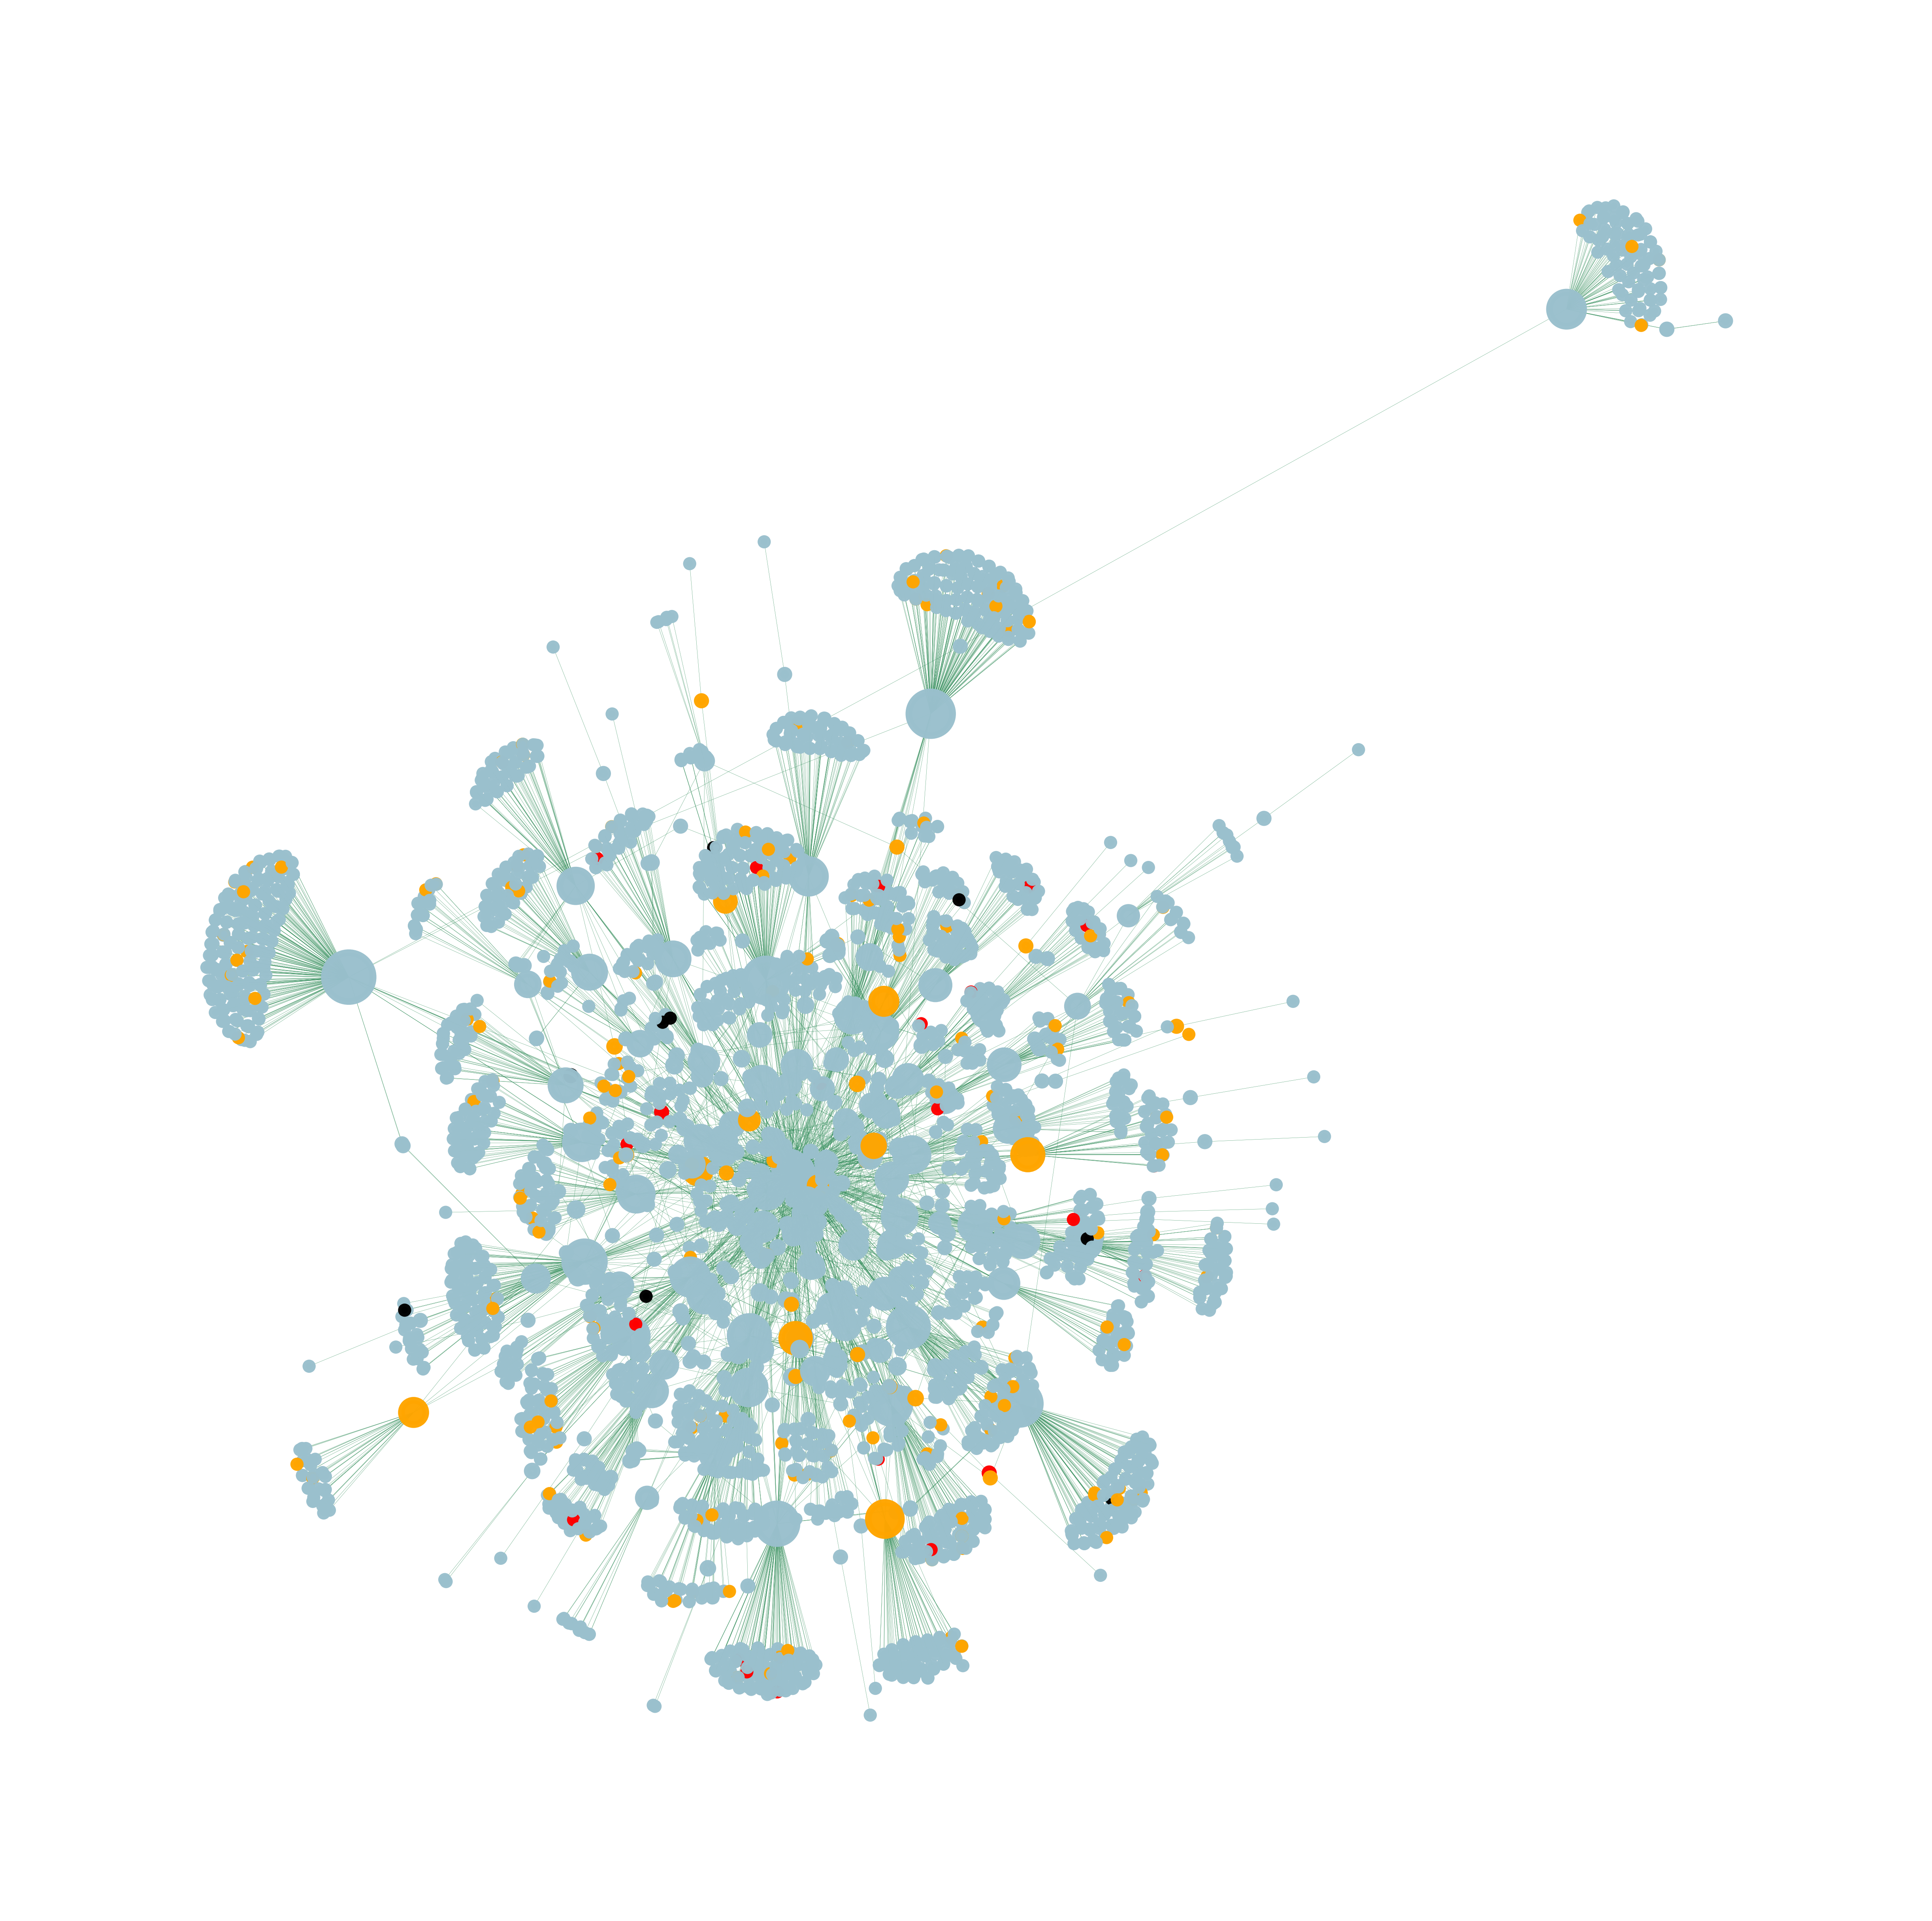

In [89]:

# 社区还原并可视化
da = dg[['账户代号','对方账号']].values
G  = nx.Graph()
for num in range(len(da)):
    G.add_edge(str(da[num,0]),str(da[num,1]))

#显示图片
plt.figure(figsize=(5,5),dpi=1200)


# 颜色设置
'''
训练集-黑样本  -- 红色 r
训练集-白羊本  -- 黑色 black
测试集 --------- 橘色 Orange
对手账户-------- 灰色
'''
colors_dic={'is_black_1':'r','is_black_0':'black','is_test':'Orange','is_other':'#9AC0CD'}

colors = flag['flag'].map(colors_dic).tolist()


#节点大小设置，与度关联
node_size = [G.degree(i)**0.75*1 for i in G.nodes()]


#kamada_kawai_layout spring_layout
nx.draw_networkx(G,
                 pos = nx.spring_layout(G),
                 node_color = colors,
                 edge_color = '#2E8B57',
                 with_labels=False,
                 #font_size = 0.01,
                 node_size = node_size,
                 alpha = 0.98,
                 width = 0.03
                 )
plt.axis('off')
plt.show()